Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [97]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [98]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [99]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [100]:
np.shape(train_dataset.reshape((-1, 28*28)))

(200000, 784)

In [101]:
np.unique(train_labels)

array([ 0.,  1.], dtype=float32)

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [102]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

V_accur_list = [] #verification accuracy list
step_list = [] # step number list
cost_list = []

In [104]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 10 == 0):
            cost_list.append(l)
            step_list.append(step)
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
            predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            V_accur_list.append(valid_accuracy)
            print('Validation accuracy: %.1f%%' % valid_accuracy)
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    pred, labels =  test_prediction.eval(), test_labels
    lama,b = weights.eval(), biases.eval()


Initialized
Loss at step 0: 18.728102
Training accuracy: 8.6%
Validation accuracy: 11.2%
Loss at step 10: 5.439679
Training accuracy: 41.1%
Validation accuracy: 43.4%
Loss at step 20: 3.917666
Training accuracy: 55.9%
Validation accuracy: 56.7%
Loss at step 30: 3.402143
Training accuracy: 61.9%
Validation accuracy: 62.1%
Loss at step 40: 3.113868
Training accuracy: 64.8%
Validation accuracy: 64.9%
Loss at step 50: 2.916015
Training accuracy: 66.9%
Validation accuracy: 66.6%
Loss at step 60: 2.766999
Training accuracy: 68.1%
Validation accuracy: 67.9%
Loss at step 70: 2.648481
Training accuracy: 69.2%
Validation accuracy: 68.6%
Loss at step 80: 2.550690
Training accuracy: 70.3%
Validation accuracy: 69.3%
Loss at step 90: 2.467821
Training accuracy: 71.0%
Validation accuracy: 69.8%
Loss at step 100: 2.395857
Training accuracy: 71.6%
Validation accuracy: 70.1%
Loss at step 110: 2.332072
Training accuracy: 71.9%
Validation accuracy: 70.4%
Loss at step 120: 2.274661
Training accuracy: 72.4%

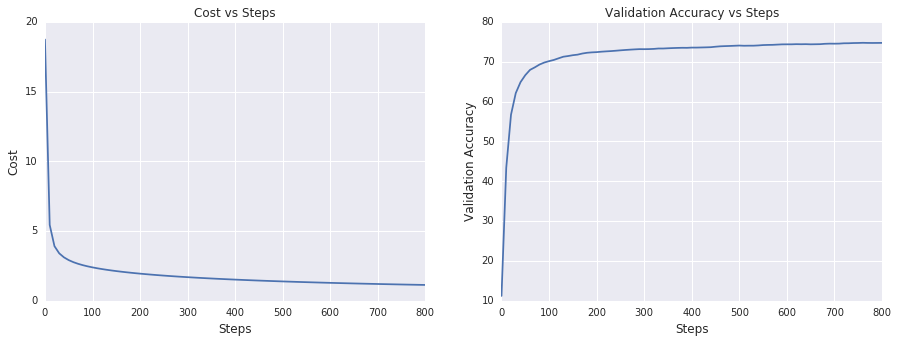

In [105]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5));
axes[0].plot(step_list, cost_list);
axes[0].set_title('Cost vs Steps');
axes[0].set_xlabel('Steps', size = 12);
axes[0].set_ylabel('Cost', size = 12);
axes[1].plot(step_list, V_accur_list);
axes[1].set_title('Validation Accuracy vs Steps');
axes[1].set_xlabel('Steps', size = 12);
axes[1].set_ylabel('Validation Accuracy', size = 12);

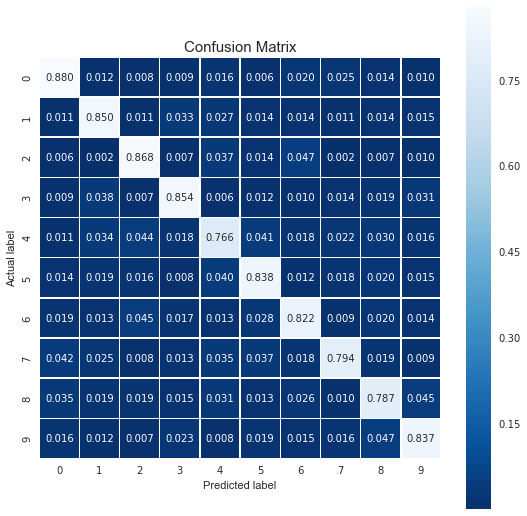

In [106]:
from sklearn import metrics
import pandas as pd
import seaborn as sns

# predictions
predicted = [np.argmax(pred[i,:], 0) for i in xrange(0,pred.shape[0])]

#actual
t_labels = [np.where(test_labels[i] == 1)[0][0] for i in xrange(0,pred.shape[0])]

cm = metrics.confusion_matrix(t_labels, predicted)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
confusion_matrix = pd.DataFrame(data = cm_normalized)
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [107]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [108]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 18.978653
Minibatch accuracy: 7.0%
Validation accuracy: 11.1%
Minibatch loss at step 500: 2.305667
Minibatch accuracy: 71.9%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 1.459496
Minibatch accuracy: 78.9%
Validation accuracy: 76.7%
Minibatch loss at step 1500: 1.459521
Minibatch accuracy: 76.6%
Validation accuracy: 77.7%
Minibatch loss at step 2000: 1.307354
Minibatch accuracy: 79.7%
Validation accuracy: 77.2%
Minibatch loss at step 2500: 1.175302
Minibatch accuracy: 75.8%
Validation accuracy: 78.6%
Minibatch loss at step 3000: 0.973494
Minibatch accuracy: 77.3%
Validation accuracy: 79.0%
Minibatch loss at step 3500: 0.659595
Minibatch accuracy: 86.7%
Validation accuracy: 78.7%
Minibatch loss at step 4000: 1.067926
Minibatch accuracy: 75.8%
Validation accuracy: 79.8%
Minibatch loss at step 4500: 0.744095
Minibatch accuracy: 79.7%
Validation accuracy: 79.4%
Minibatch loss at step 5000: 0.527495
Minibatch accuracy: 85.9%
Validation accurac

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt

V_accur_list = [] #verification accuracy list
step_list = [] # step number list
cost_list = []

In [110]:
# Setting up the graph always comes first

batch_size = 128
n_hidden_nodes = 1024
image_size = 28

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be 
    # fed at runtime with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_01 = tf.Variable(
    tf.truncated_normal([image_size * image_size, n_hidden_nodes]))
    weights_12 = tf.Variable(tf.truncated_normal([n_hidden_nodes, num_labels]))
    biases_01 = tf.Variable(tf.zeros([n_hidden_nodes]))
    biases_12 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    z_01= tf.matmul(tf_train_dataset, weights_01) + biases_01
    h1 = tf.nn.relu(z_01)
    z_12 = tf.matmul(h1, weights_12) + biases_12
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(z_12, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(z_12)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_01) + biases_01), weights_12) + biases_12)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_01) + biases_01), weights_12) + biases_12) 

In [111]:
num_steps = 6001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            cost_list.append(l)
            step_list.append(step)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            V_accur_list.append(valid_accuracy)
            print("Validation accuracy: %.1f%%" % valid_accuracy)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    lama = weights_01.eval()
    lama2 = weights_12.eval()

Initialized
Minibatch loss at step 0: 374.500977
Minibatch accuracy: 13.3%
Validation accuracy: 28.8%
Minibatch loss at step 100: 46.471622
Minibatch accuracy: 72.7%
Validation accuracy: 78.8%
Minibatch loss at step 200: 57.415054
Minibatch accuracy: 72.7%
Validation accuracy: 79.8%
Minibatch loss at step 300: 43.548996
Minibatch accuracy: 80.5%
Validation accuracy: 78.7%
Minibatch loss at step 400: 11.263430
Minibatch accuracy: 88.3%
Validation accuracy: 78.8%
Minibatch loss at step 500: 17.382776
Minibatch accuracy: 74.2%
Validation accuracy: 80.5%
Minibatch loss at step 600: 4.176809
Minibatch accuracy: 89.8%
Validation accuracy: 81.9%
Minibatch loss at step 700: 5.441994
Minibatch accuracy: 85.9%
Validation accuracy: 80.5%
Minibatch loss at step 800: 6.871696
Minibatch accuracy: 80.5%
Validation accuracy: 80.5%
Minibatch loss at step 900: 9.167776
Minibatch accuracy: 78.9%
Validation accuracy: 80.8%
Minibatch loss at step 1000: 11.003666
Minibatch accuracy: 75.8%
Validation accurac

In [112]:
#very simple plotting
#fig = plt.figure(1)
#ax1 = fig.add_subplot(111)
#ax1.set_xlabel('Steps')
#ax1.set_ylabel('Cost')
#ax1.set_title('Cost vs Steps')
#ax1.plot(step2_list,cost2_list,);

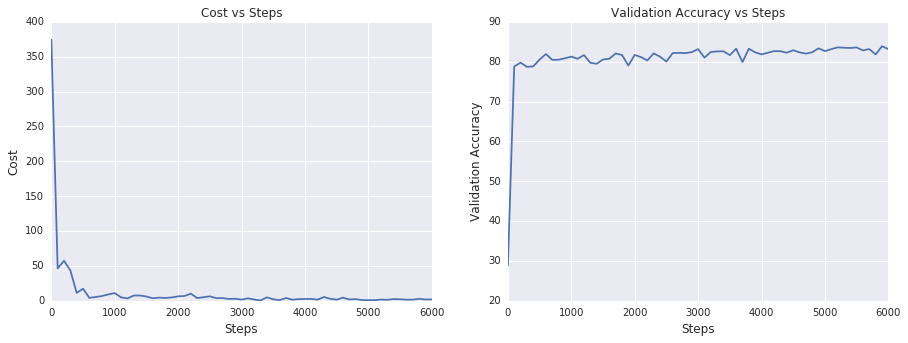

In [113]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5));
axes[0].plot(step_list, cost_list);
axes[0].set_title('Cost vs Steps');
axes[0].set_xlabel('Steps', size = 12);
axes[0].set_ylabel('Cost', size = 12);
axes[1].plot(step_list, V_accur_list);
axes[1].set_title('Validation Accuracy vs Steps');
axes[1].set_xlabel('Steps', size = 12);
axes[1].set_ylabel('Validation Accuracy', size = 12);